# NATURAL LANGUAGE PROCESSING WITH TRANSFORMERS
# Α Pos Tagger trained on UD treebank with finetuning a BERT model

# Native BERT implementation

In [2]:
# First install some extra packages
# ! pip install pyconll # for UD treebank reading
# ! pip install bert-tensorflow # for using bert model

In [1]:
import pyconll, pickle, os, random, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from sklearn.metrics.classification import UndefinedMetricWarning

from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [2]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [3]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [4]:
def download_files():
    print('Downloading English treebank...')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', UD_ENGLISH_DEV)
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', UD_ENGLISH_TEST)
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', UD_ENGLISH_TRAIN)
    print('Treebank downloaded.')
    print('Downloading pre-trained BERT model...')
    urllib.request.urlretrieve('https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip', 'uncased_L-12_H-768_A-12.zip')
    print('Pre-trained BERT model downloaded.')
    print('Extracting zip file...')
    zip_ref = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Zip file extracted.')

First we download English treebank and pre-trained BERT model:

In [5]:
download_files()

Treebank downloaded.
Pre-trained BERT model downloaded.
Extracting zip file...
Zip file extracted.


# Preprocessing

In [6]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [7]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

Print some statistics

In [8]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  1781
Tagged words in train set: 43518
Tagged sentences in dev set:  156
Tagged words in dev set: 2722
Tagged sentences in test set:  153
Tagged words in test set: 3408
****************************************
Total sentences in dataset: 2090


In [9]:
print(train_sentences[0])

[('distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]


In [10]:
# Some usefull functions
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

In [14]:
train_text = text_sequence(train_sentences)
test_text = text_sequence(test_sentences)
val_text = text_sequence(val_sentences)

train_label = tag_sequence(train_sentences)
test_label= tag_sequence(test_sentences)
val_label= tag_sequence(val_sentences)

In [15]:
MAX_SEQUENCE_LENGTH=len(max(train_sentences+val_sentences+test_sentences, key=len))
print('Max sentence length:',MAX_SEQUENCE_LENGTH)

Max sentence length: 209


In [16]:
train_text[0:1], train_label[0:1]

([['distribution',
   'of',
   'this',
   'license',
   'does',
   'not',
   'create',
   'an',
   'attorney',
   '-',
   'client',
   'relationship',
   '.']],
 [['NOUN',
   'ADP',
   'DET',
   'NOUN',
   'AUX',
   'PART',
   'VERB',
   'DET',
   'NOUN',
   'PUNCT',
   'NOUN',
   'NOUN',
   'PUNCT']])

Convert our UD dataset to NER conllu format and save in 'data' directory:

In [17]:
def convert_ner_format(text, label, file):
    with open(file, 'w') as f:
        words=0
        i=0
        for zip_i in zip(text, label):
            a, b = tuple(zip_i)
            for r in range(len(a)):
                item = a[r]+' '+b[r]
                f.write("%s\n" % item)
                words+=1
            f.write("\n")
            i+=1
            #if i==3: break
    print('Sentences:',i,'Words:',words)

In [18]:
convert_ner_format(train_text, train_label, 'data/train.txt')
convert_ner_format(test_text, test_label, 'data/test.txt')
convert_ner_format(val_text, val_label, 'data/dev.txt')

Sentences: 1781 Words: 43518
Sentences: 153 Words: 3408
Sentences: 156 Words: 2722


# Run BERT fine-tuning

In [19]:
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH+2 # +2 for [CLS], [SEP] tokens

In [20]:
! rm -rf ./output/result_dir/*

In [18]:
%run bert_pos.py   \
    --task_name="POS"  \
    --do_lower_case=False \ # Our dataset is already lower cased!
    --crf=False \
    --do_train=True   \
    --do_eval=True   \
    --do_predict=True \
    --data_dir=data   \
    --vocab_file=uncased_L-12_H-768_A-12/vocab.txt  \
    --bert_config_file=uncased_L-12_H-768_A-12/bert_config.json \
    --init_checkpoint=uncased_L-12_H-768_A-12/bert_model.ckpt   \
    --max_seq_length=$MAX_SEQUENCE_LENGTH  \
    --train_batch_size=16   \
    --learning_rate=2e-5   \
    --num_train_epochs=4.0   \
    --output_dir=./output/result_dir

W0521 22:59:06.862257 140480743667456 estimator.py:1924] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7fc402d87158>) includes params argument, but params are not passed to Estimator.
I0521 22:59:06.863543 140480743667456 estimator.py:201] Using config: {'_model_dir': './output/result_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc4044af9b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I0521 22:59:07.861638 140480743667456 bert_pos.py:623] ***** Running training *****
I0521 22:59:07.862088 140480743667456 bert_pos.py:624]   Num examples = 1614
I0521 22:59:07.862474 140480743667456 bert_pos.py:625]   Batch size = 16
I0521 22:59:07.862802 140480743667456 bert_pos.py:626]   Num steps = 403
W0521 22:59:07.867192 140480743667456 deprecation.py:323] From /home/dbnet/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W0521 22:59:07.886538 140480743667456 deprecation.py:323] From /home/dbnet/stout/BERT-POS/bert_pos.py:363: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
I0521 22:59:07.901232 140480743667456 estimator.py:1111] Calling model_fn.
I0521 22:59:07.9

I0521 22:59:10.689037 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.689307 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 22:59:10.689580 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.689836 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 22:59:10.690105 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.690366 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 22:59:10.690628 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/attention/output/

I0521 22:59:10.704452 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.704741 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
I0521 22:59:10.705023 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
I0521 22:59:10.705284 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
I0521 22:59:10.705552 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.705822 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.706099 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (

I0521 22:59:10.725978 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.726240 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 22:59:10.726515 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.726801 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 22:59:10.727092 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 22:59:10.727386 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 22:59:10.727649 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/attention/output/

I0521 22:59:22.420811 140480743667456 session_manager.py:493] Done running local_init_op.
I0521 22:59:26.711293 140480743667456 basic_session_run_hooks.py:594] Saving checkpoints for 0 into ./output/result_dir/model.ckpt.
I0521 23:00:18.262902 140480743667456 tpu_estimator.py:1858] global_step/sec: 2.17923
I0521 23:00:18.264348 140480743667456 tpu_estimator.py:1859] examples/sec: 34.8676
I0521 23:01:02.011348 140480743667456 tpu_estimator.py:1858] global_step/sec: 2.2858
I0521 23:01:02.012377 140480743667456 tpu_estimator.py:1859] examples/sec: 36.5728
I0521 23:01:46.407683 140480743667456 tpu_estimator.py:1858] global_step/sec: 2.25244
I0521 23:01:46.408595 140480743667456 tpu_estimator.py:1859] examples/sec: 36.039
I0521 23:02:31.157800 140480743667456 tpu_estimator.py:1858] global_step/sec: 2.23463
I0521 23:02:31.158691 140480743667456 tpu_estimator.py:1859] examples/sec: 35.7541
I0521 23:02:32.094064 140480743667456 basic_session_run_hooks.py:594] Saving checkpoints for 403 into ./

I0521 23:02:33.916749 140480743667456 bert_pos.py:640]   Num examples = 143
I0521 23:02:33.917185 140480743667456 bert_pos.py:641]   Batch size = 8
I0521 23:02:33.937536 140480743667456 estimator.py:1111] Calling model_fn.
I0521 23:02:33.938038 140480743667456 tpu_estimator.py:2532] Running eval on CPU
I0521 23:02:33.938572 140480743667456 bert_pos.py:458] *** Features ***
I0521 23:02:33.938973 140480743667456 bert_pos.py:460]   name = input_ids, shape = (?, 211)
I0521 23:02:33.939327 140480743667456 bert_pos.py:460]   name = label_ids, shape = (?, 211)
I0521 23:02:33.939656 140480743667456 bert_pos.py:460]   name = mask, shape = (?, 211)
I0521 23:02:33.939974 140480743667456 bert_pos.py:460]   name = segment_ids, shape = (?, 211)
I0521 23:02:36.603968 140480743667456 bert_pos.py:489] **** Trainable Variables ****
I0521 23:02:36.604617 140480743667456 bert_pos.py:495]   name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
I0521 23:02:36.605110 14048074366745

I0521 23:02:36.621374 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.621640 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.621915 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.622236 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:36.622500 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.622769 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:36.623026 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_3/attention/self/key/bias:0, shape = (76

I0521 23:02:36.642405 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.642685 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:36.642969 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.643261 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.643537 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.643839 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
I0521 23:02:36.644603 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_6/inter

I0521 23:02:36.662043 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.662326 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.662604 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.662883 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:36.663184 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:36.663455 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:36.663744 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_10/attention/self/key/bias:0, shape =

I0521 23:02:40.295973 140480743667456 estimator.py:2012] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).
I0521 23:02:40.296931 140480743667456 estimator.py:2039] Saving 'checkpoint_path' summary for global step 403: ./output/result_dir/model.ckpt-403
I0521 23:02:40.297545 140480743667456 error_handling.py:93] evaluation_loop marked as finished
I0521 23:02:40.298076 140480743667456 bert_pos.py:653] ***** Eval results *****
I0521 23:02:40.298760 140480743667456 bert_pos.py:656] ***********************************************
I0521 23:02:40.299173 140480743667456 bert_pos.py:657] ********************P = 0.8601175613195139*********************
I0521 23:02:40.299687 140480743667456 bert_pos.py:658] ********************R = 0.8392247131387066*********************
I0521 23:02:40.299961 140480743667456 bert_pos.py:659] 

I0521 23:02:41.113238 140480743667456 bert_pos.py:308] *** Example ***
I0521 23:02:41.114897 140480743667456 bert_pos.py:309] guid: test-2
I0521 23:02:41.116538 140480743667456 bert_pos.py:311] tokens: unless otherwise agreed to by the parties in writing , li ##cens ##or offers the work as - is and makes no representations or warrant ##ies of any kind concerning the materials , express , implied , statutory or otherwise , including , without limitation , warrant ##ies of title , merchant ##ibility , fitness for a particular purpose , non ##in ##fr ##inge ##ment , or the absence of late ##nt or other defects , accuracy , or the presence of absence of errors , whether or not discover ##able .
I0521 23:02:41.119356 140480743667456 bert_pos.py:312] input_ids: 101 4983 4728 3530 2000 2011 1996 4243 1999 3015 1010 5622 19023 2953 4107 1996 2147 2004 1011 2003 1998 3084 2053 15066 2030 10943 3111 1997 2151 2785 7175 1996 4475 1010 4671 1010 13339 1010 15201 2030 4728 1010 2164 1010 2302 22718

I0521 23:02:44.000418 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.000691 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
I0521 23:02:44.000997 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
I0521 23:02:44.001280 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
I0521 23:02:44.001553 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.001839 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.002105 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (

I0521 23:02:44.020193 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.020454 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:44.020725 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.020979 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:44.021231 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.021482 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
I0521 23:02:44.021746 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_5/attention/output/

I0521 23:02:44.035148 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.035406 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
I0521 23:02:44.035679 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
I0521 23:02:44.035950 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
I0521 23:02:44.036232 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.036504 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.036773 140480743667456 bert_pos.py:495]   name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (

I0521 23:02:44.059241 140480743667456 bert_pos.py:495]   name = bert/pooler/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
I0521 23:02:44.059664 140480743667456 bert_pos.py:495]   name = dense_37/kernel:0, shape = (768, 21)
I0521 23:02:44.059941 140480743667456 bert_pos.py:495]   name = dense_37/bias:0, shape = (21,)
I0521 23:02:44.060263 140480743667456 bert_pos.py:495]   name = crf_loss/transition:0, shape = (21, 21)
I0521 23:02:44.060698 140480743667456 estimator.py:1113] Done calling model_fn.
I0521 23:02:44.406044 140480743667456 monitored_session.py:222] Graph was finalized.
I0521 23:02:44.408295 140480743667456 saver.py:1270] Restoring parameters from ./output/result_dir/model.ckpt-403
I0521 23:02:44.883916 140480743667456 session_manager.py:491] Running local_init_op.
I0521 23:02:44.927063 140480743667456 session_manager.py:493] Done running local_init_op.
I0521 23:02:47.660350 140480743667456 error_handling.py:93] prediction_loop marked as finished
I0521 23:02:47.661215 140480

# Evaluation

## Classification report

Results are stored in *'./output/result_dir/'*. Lets see the classification report:

In [19]:
predictions ='./output/result_dir/label_test.txt'

In [20]:
y_true = []
y_pred = []
with open(predictions) as fp:
    for line in fp:
        line = line.split()
        if not line[0].startswith('##') and not line[1].startswith('##') :#and not line[2].startswith('##'):
            y_true.append(line[1])
            y_pred.append(line[2])

In [21]:
len(y_true), len(y_pred)

(3408, 3408)

In [22]:
name='Bert fine-tuned model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


------------ Result of Bert fine-tuned model ----------

              precision    recall  f1-score   support

          ##     0.0000    0.0000    0.0000         0
         ADJ     0.9217    0.8929    0.9070       224
         ADP     0.9817    0.9877    0.9847       488
         ADV     0.9302    0.9160    0.9231       131
         AUX     0.9957    1.0000    0.9979       234
       CCONJ     0.9896    0.9896    0.9896        96
         DET     0.9955    1.0000    0.9977       439
        INTJ     1.0000    1.0000    1.0000         2
        NOUN     0.9736    0.9788    0.9762       753
         NUM     0.9385    1.0000    0.9683        61
        PART     0.9565    1.0000    0.9778        66
        PRON     1.0000    0.9340    0.9659       106
       PROPN     0.9405    0.8778    0.9080        90
       PUNCT     1.0000    0.9971    0.9985       339
       SCONJ     0.9565    0.8627    0.9072        51
        VERB     0.9580    0.9785    0.9681       326
           X     1.0000

In [23]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9733
f1-macro score: 0.9100


## Confusion matrix

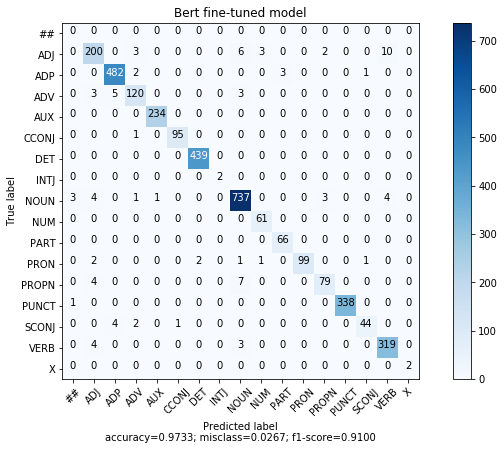

In [26]:
tags = sorted(set(y_true+y_pred))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=tags, title=name, normalize=False)

## Note

**##** label is comming from original-to-tokenized alignment code in function <font color=blue>convert_single_example(ex_index, example, label_list, max_seq_length, tokenizer, mode)</font>  in *bert_pos.py*. Following suggestions from [WordPiece tokenization](https://github.com/google-research/bert) part, for pos tagging task input sentences are converted to the following format:

In [1]:
# orig_tokens = ["John", "Johanson", "'s",  "house"]
# labels      = ["NNP",  "NNP",      "POS", "NN"]

# bert_tokens = ['[CLS]", "john", "johan", "##son", "'",   "s",  "house", "[SEP]"]
# bert_labels = ['[CLS]", "NNP",  "NNP",   "##",    "POS", "##", "NN",    "[SEP]"]